In [2]:
# install keras tuner
!pip install keras_tuner -q

     |████████████████████████████████| 98 kB 4.0 MB/s 


In [3]:
# imports
import tensorflow as tf
import numpy as np
from tensorflow import keras
from keras.datasets import cifar10
from keras import models, activations
from tensorflow.keras.optimizers import SGD, Adam
import keras_tuner as kt
from keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten, InputLayer
import matplotlib.pyplot as plt
from keras_tuner.tuners import RandomSearch, BayesianOptimization 

# Question 2

In [ ]:
#imports
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# kernels 
kernel1 = (1./9.0) * np.array([[1, 1, 1],
                            [1, 1, 1],
                            [1, 1, 1]])

kernel2 = np.array([[-1, -1, -1],
                    [-1, 8, -1],
                    [-1, -1, -1]])

kernel3 = np.array([[-1,-2, -1],
                    [0, 0, 0],
                    [1, 2, 1]])

kernel4 = np.array([[-1, 0, 1],
                    [-2, 0, 2],
                    [-1, 0, 1]])

kernels = [kernel1, kernel2, kernel3, kernel4]

shape of orginal image : (512, 512)


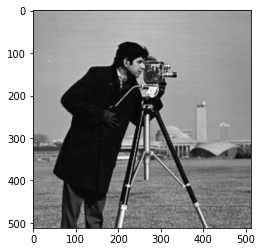

In [ ]:
# read image
img = cv2.imread('/content/img1.jpg', flags=cv2.IMREAD_GRAYSCALE)
print(f'shape of orginal image : {img.shape}')
plt.imshow(img, cmap='gray')
plt.show()

### kernel 1

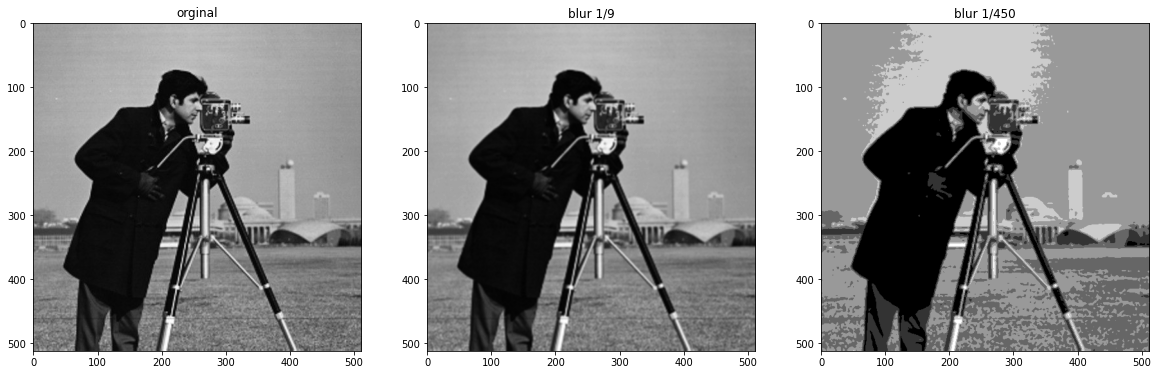

In [ ]:
def convolve(src, kernel):
  dest_img = cv2.filter2D(src=img, ddepth=-1, kernel=kernel)
  return dest_img

plt.figure(figsize=(20,10))
plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title('orginal')


plt.subplot(1, 3, 2)
plt.imshow(convolve(img, kernel1), cmap='gray')
plt.title('blur 1/9')

plt.subplot(1, 3, 3)
plt.imshow(convolve(img, kernel1/50.), cmap='gray')
plt.title('blur 1/450')

plt.show()

### kernel 2

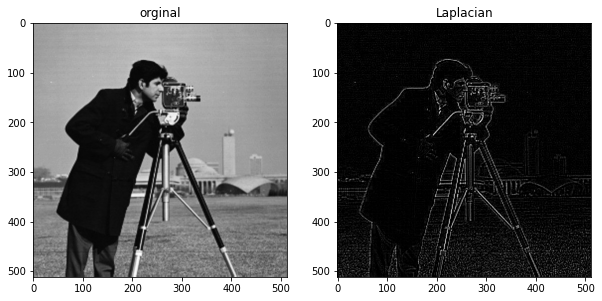

In [ ]:
plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title('orginal')

plt.subplot(1, 2, 2)
plt.imshow(convolve(img, kernel2), cmap='gray')
plt.title('Laplacian')
plt.show()

### kernel 3

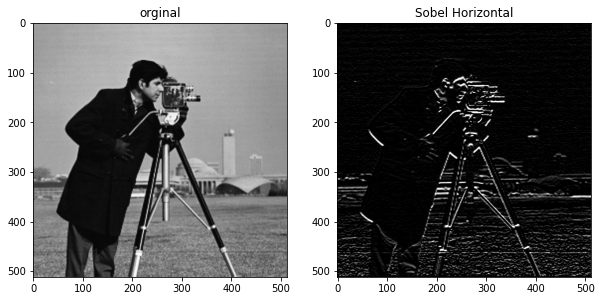

In [ ]:
plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title('orginal')

plt.subplot(1, 2, 2)
plt.imshow(convolve(img, kernel3), cmap='gray')
plt.title('Sobel Horizontal')
plt.show()

### kernel 4

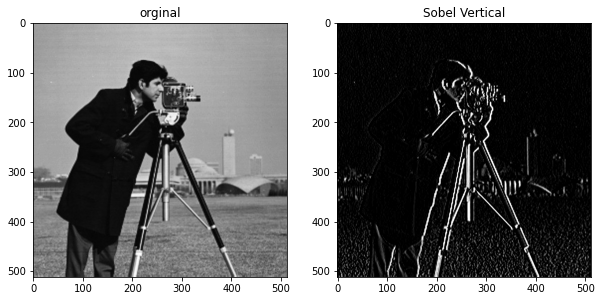

In [ ]:
plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title('orginal')

plt.subplot(1, 2, 2)
plt.imshow(convolve(img, kernel4), cmap='gray')
plt.title('Sobel Vertical')
plt.show()

# Question 3


### Load Data

In [4]:
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()
print(f'x_train shape : {X_train.shape}')
print(f'x_test shape : {X_test.shape}')
print(f'y_train shape : {Y_train.shape}')
print(f'y_test shape : {Y_test.shape}')

CLASS_NUMS = len(np.unique(Y_train))
print('class nums : {class_num}'.format(class_num = CLASS_NUMS))
class_names = ['airplane', 'automobile', 'bird','cat', 'deer','dog', 'frog','horse', 'ship','truck']
print(class_names)

170508288/170498071 [==============================] - 6s 0us/step
x_train shape : (50000, 32, 32, 3)
x_test shape : (10000, 32, 32, 3)
y_train shape : (50000, 1)
y_test shape : (10000, 1)
class nums : 10
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


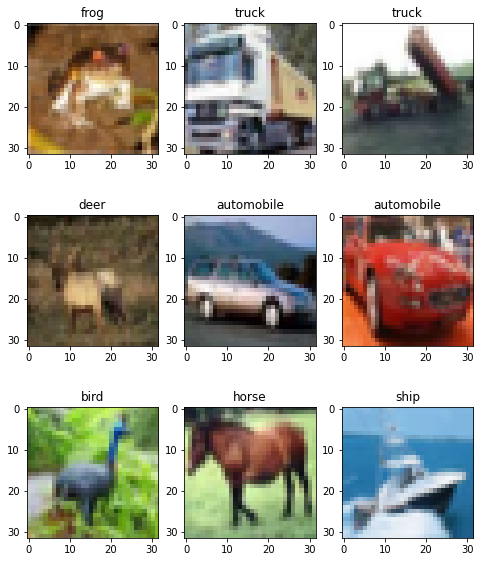

In [5]:
# visualize data
plt.figure(figsize=(8,10))
for i in range(9):
  plt.subplot(3, 3, i+1)
  plt.imshow(X_train[i])
  plt.title(class_names[Y_train[i][0]])
plt.show()

### PreProcessing


In [6]:
# pre processing
def normalize_data(x, y):
  y = tf.keras.utils.to_categorical(y.reshape((-1,)), dtype="float32")
  x = x.astype('float32')
  x = x / 255.0
  return x, y

x_train, y_train = normalize_data(x=X_train, y=Y_train)
x_test, y_test = normalize_data(x=X_test, y=Y_test)
print(f'x_train shape : {x_train.shape}')
print(f'x_test shape : {x_test.shape}')
print(f'y_train shape : {y_train.shape}')
print(f'y_test shape : {y_test.shape}')

x_train shape : (50000, 32, 32, 3)
x_test shape : (10000, 32, 32, 3)
y_train shape : (50000, 10)
y_test shape : (10000, 10)


### build model

In [7]:
!rm -rf /content/CIFAR10_PROJECT

def build_model(hp):  
    model = models.Sequential()
    model.add(InputLayer( input_shape=x_train.shape[1:]))
    
    ## convolution layers 
    drop_out_rate = 0.2
    for i in range(hp.Int('n_conv_layers', min_value=2, max_value=5, step=1)):
        model.add(
            Conv2D(hp.Int(f'conv2D_{i}_units',
                                min_value=32,
                                max_value=256,
                                step=32),
                                padding='same',
                                kernel_size=(3, 3), activation='relu'))
        if i % 2 == 1:
          model.add(MaxPooling2D((2, 2)))
          model.add(Dropout(drop_out_rate))
          drop_out_rate +=0.1
        
        
    ## fully connected layers    
    model.add(Flatten())
    
    for i in range(hp.Int('n_fully_connected_layers', min_value=1, max_value=4, step=1)):
        model.add(
                  Dense(hp.Choice(f'n_nodes_{i}',
                                  values=[32, 64, 128, 256]), activation= 'relu'))
    
    model.add(Dropout(0.5))
    model.add(Dense(CLASS_NUMS, activation= 'softmax'))
    opt = Adam(learning_rate= hp.Float("lr", min_value=1e-4, max_value=1e-3))

    model.compile(optimizer=opt,
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])

    return model

tuner = BayesianOptimization(
  build_model,
  objective='val_accuracy',
  max_trials=5,
  executions_per_trial=1,
  directory='CIFAR10_PROJECT',
  project_name='KerasTuner')


NUM_EPOCH = 20
tuner.search(x=x_train,
             y=y_train,
             epochs=NUM_EPOCH,
             batch_size=128,
             validation_split= 0.15)

print('**' * 50)
print(tuner.get_best_models()[0].summary())
print(tuner.get_best_hyperparameters()[0].values)

Trial 5 Complete [00h 15m 15s]
val_accuracy: 0.7476000189781189

Best val_accuracy So Far: 0.8114666938781738
Total elapsed time: 01h 07m 20s
INFO:tensorflow:Oracle triggered exit
****************************************************************************************************
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 256)       7168      
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 192)       442560    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 192)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 192)       0         
                                       

In [8]:
## result summary
tuner.results_summary()

Results summary
Results in CIFAR10_PROJECT/KerasTuner
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
n_conv_layers: 5
conv2D_0_units: 256
conv2D_1_units: 192
n_fully_connected_layers: 2
n_nodes_0: 64
lr: 0.000350836963524948
conv2D_2_units: 192
conv2D_3_units: 256
n_nodes_1: 64
n_nodes_2: 32
conv2D_4_units: 32
Score: 0.8114666938781738
Trial summary
Hyperparameters:
n_conv_layers: 5
conv2D_0_units: 256
conv2D_1_units: 256
n_fully_connected_layers: 4
n_nodes_0: 64
lr: 0.0008314291989775435
conv2D_2_units: 256
conv2D_3_units: 256
n_nodes_1: 32
n_nodes_2: 32
conv2D_4_units: 32
n_nodes_3: 32
Score: 0.7586666941642761
Trial summary
Hyperparameters:
n_conv_layers: 4
conv2D_0_units: 64
conv2D_1_units: 224
n_fully_connected_layers: 3
n_nodes_0: 256
lr: 0.00066640419930834
conv2D_2_units: 32
conv2D_3_units: 32
n_nodes_1: 32
n_nodes_2: 32
Score: 0.7572000026702881
Trial summary
Hyperparameters:
n_conv_layers: 5
conv2D_0_units: 256
conv2D_1_u

In [9]:
model = tuner.get_best_models(num_models=1)[0]
print (model.summary())
# Evaluate the best model.
loss, accuracy = model.evaluate(x_test, y_test)
print('loss Test:', loss)
print('accuracy Test:', accuracy)
model.save('prueba1.h5')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 256)       7168      
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 192)       442560    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 192)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 192)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 192)       331968    
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 256)       442624    
                                                        

In [10]:
loss, accuracy = model.evaluate(x_train, y_train)
print('loss Train:', loss)
print('accuracy Train:', accuracy)

1563/1563 [==============================] - 23s 15ms/step - loss: 0.2601 - accuracy: 0.9147
loss Train: 0.26011723279953003
accuracy Train: 0.9146999716758728
